In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from matplotlib import cm
from PIL import Image

#import dlib # EXTRA


<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0865044, r2, r3, r4, r5</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:

0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. **Provide strong arguments** for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------

# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [7]:
# Input data files are available in the read-only "../input/" directory
# csv_train_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train_set.csv'
# csv_test_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test_set.csv'
# npy_train_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'
# npy_test_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'


###
# IMPORTANT
# MODIFY THE FOLLOWING PATHS
###
csv_train_path = 'data/train_set.csv'
csv_test_path = 'data/test_set.csv'
npy_train_path = 'data/train/train_{}.npy'
npy_test_path = 'data/test/test_{}.npy'

train = pd.read_csv(csv_train_path, index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(csv_test_path, index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load(npy_train_path.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load(npy_test_path.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [ ]:
# The training set contains an identifier, name, image information and class label
train.head(1)

In [ ]:
# The test set only contains an identifier and corresponding image information.
test.head(1)

In [3]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


## TO DO
* Make a method for checking all the images 
* Tune the Haar cascade hyperparameters 
* Validate the quality with the test test
* **the quality of output is determined by the quality of the input**

## SOME RESOURCES
* https://towardsdatascience.com/face-detection-with-haar-cascade-727f68dafd08
* https://docs.opencv.org/3.4/d2/d99/tutorial_js_face_detection.html

In [64]:
import faceBlendCommon as fbc 

class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """

    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        faces = self.detect_faces(img)
        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

In [8]:
class FaceAlignProcessor():
    """Class for performing Face Alignment """

    def __init__(self, path, size):
        ''' Define the face detector and the landmark detector '''
        # Get the face detector
        self.faceDetector = dlib.get_frontal_face_detector()
        # The landmark detector is implemented in the shape_predictor class
        self.landmarkDetector = dlib.shape_predictor(path)
        self.dt = None
        self.pointsAvg = None
        self.h, self.w = size
        
    def fit(self, train):
        ''' Computes the denulay triangulation using the trainset '''
#         h, w = size
        points = []
        for i, idx in enumerate((np.array(train['img']))):
            try:
                # Compute the landmark points
                points1 = np.array(fbc.getLandmarks(self.faceDetector, self.landmarkDetector, idx, 0.5))
                # Convert image to floating point in the range 0 to 1
                idx = np.float32(idx)/255.0
                # Normalize image to output coordinates.
                imNorm1, points1 = fbc.normalizeImagesAndLandmarks((self.h, self.w), idx, points1)
                points.append(points1)
            except:
                print(f'Error with imagee {i}')
        self.pointsAvg = np.sum(np.array(points), axis=0)//len(points)
        rect = (0, 0, self.w, self.h)
        self.dt = fbc.calculateDelaunayTriangles(rect, np.uint16(self.pointsAvg))
        print('LandMark correctly trained')
        
    def preprocess(self, train):
        ''' Performs the alignment using the normalized face and the defined triangulation '''
#         h, w = size
        norm_imgs = []
        alin_imgs = []
        boundaryPoints = fbc.getEightBoundaryPoints(self.h, self.w)
        for i, idx in enumerate((np.array(train['img']))):
            try:
                # Compute the landmark points
                points1 = np.array(fbc.getLandmarks(self.faceDetector, self.landmarkDetector, idx, 0.5))
                # Convert image to floating point in the range 0 to 1
                idx = np.float32(idx)/255.0
                # Normalize image to output coordinates.
                imNorm1, points1 = fbc.normalizeImagesAndLandmarks((self.h, self.w), idx, points1)
                imWarp = fbc.warpImage(imNorm1, points1, self.pointsAvg.tolist(), self.dt)
            except:
                print(f'Error with imagee {i}')
                imNorm1 = np.zeros((self.h, self.w, 3))
                imWarp = imNorm1.copy()
            norm_imgs.append(imNorm1)
            alin_imgs.append(imWarp)
        return np.uint8(255*np.array(norm_imgs)), np.uint8(255*np.array(alin_imgs))
            
    def __call__(self, data):
        return self.preprocess(data)

In [17]:
# parameter to play with 
h = 128
w = 128
FACE_SIZE = (h, w)

PREDICTOR_PATH = "packages/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
preprocessor = FaceAlignProcessor(PREDICTOR_PATH, (h, w))
points = preprocessor.fit(train)

Error with imagee 65
LandMark correctly trained


In [16]:
def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

In [18]:
train_X0, train_X = preprocessor.preprocess(train)
train_y = train['class'].values

Error with imagee 65


In [19]:
testX0, test_X = preprocessor.preprocess(test)


Error with imagee 92
Error with imagee 122
Error with imagee 130
Error with imagee 155
Error with imagee 222
Error with imagee 232
Error with imagee 262
Error with imagee 322
Error with imagee 399
Error with imagee 498
Error with imagee 537
Error with imagee 650
Error with imagee 721
Error with imagee 746
Error with imagee 864
Error with imagee 939
Error with imagee 949
Error with imagee 954
Error with imagee 1039
Error with imagee 1071
Error with imagee 1093
Error with imagee 1097
Error with imagee 1112
Error with imagee 1121
Error with imagee 1130
Error with imagee 1236
Error with imagee 1244
Error with imagee 1383
Error with imagee 1625
Error with imagee 1638


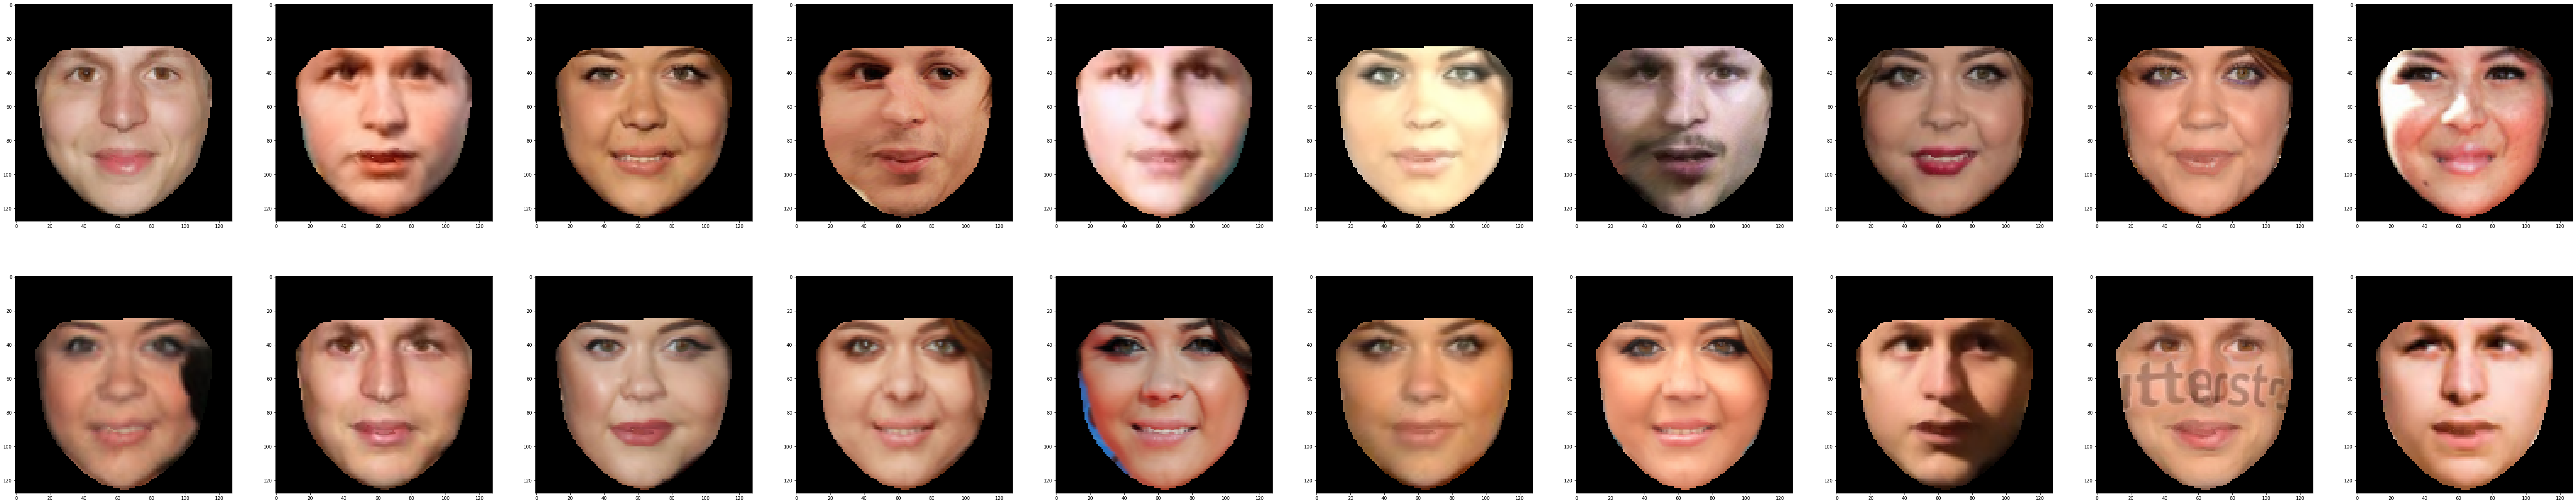

In [40]:
# plot faces of Michael and Sarah
plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

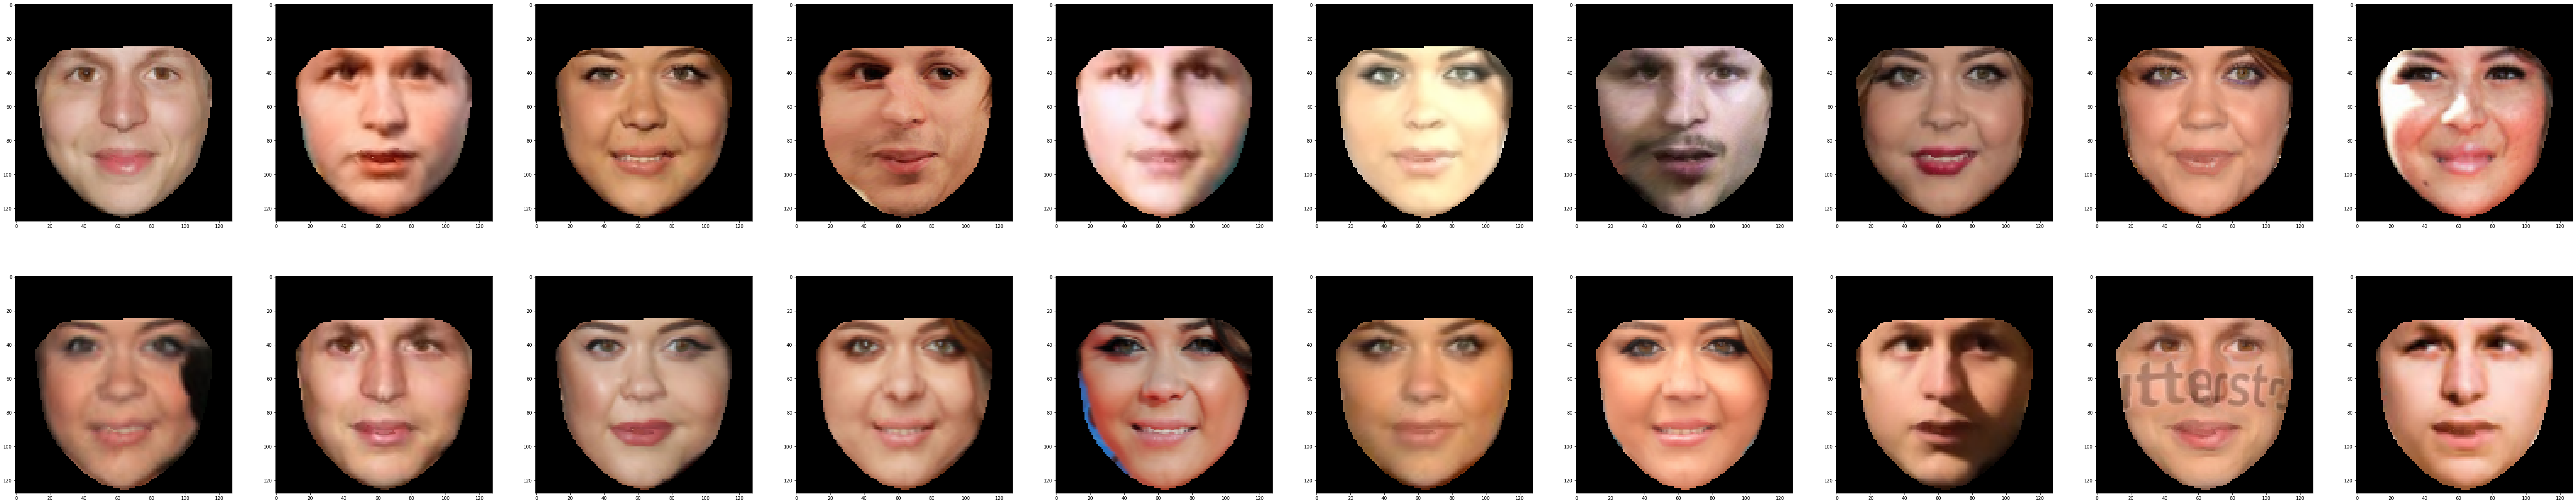

In [21]:
# plot faces of Michael and Sarah
plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

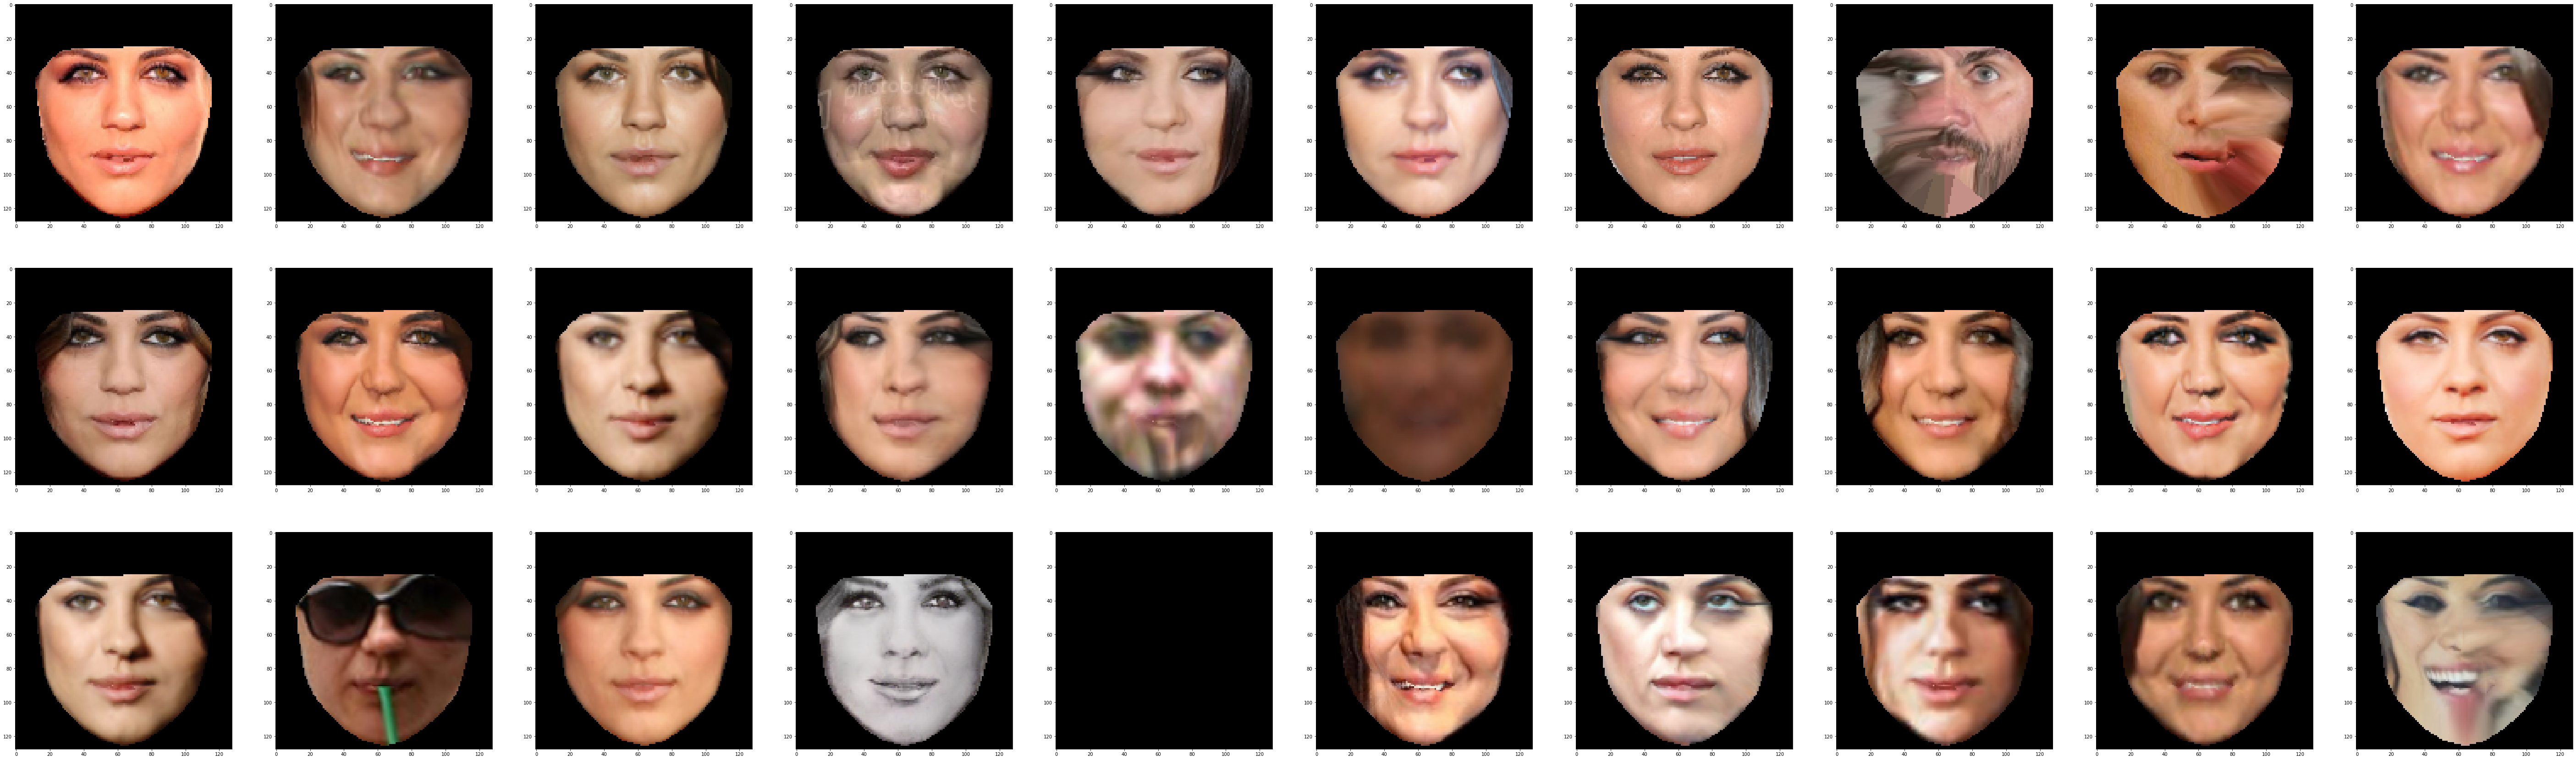

In [22]:
# plot faces of Mila
plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

**Visualise**

Let's plot a few examples.

In [65]:
# parameter to play with 
FACE_SIZE = (128, 128)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values


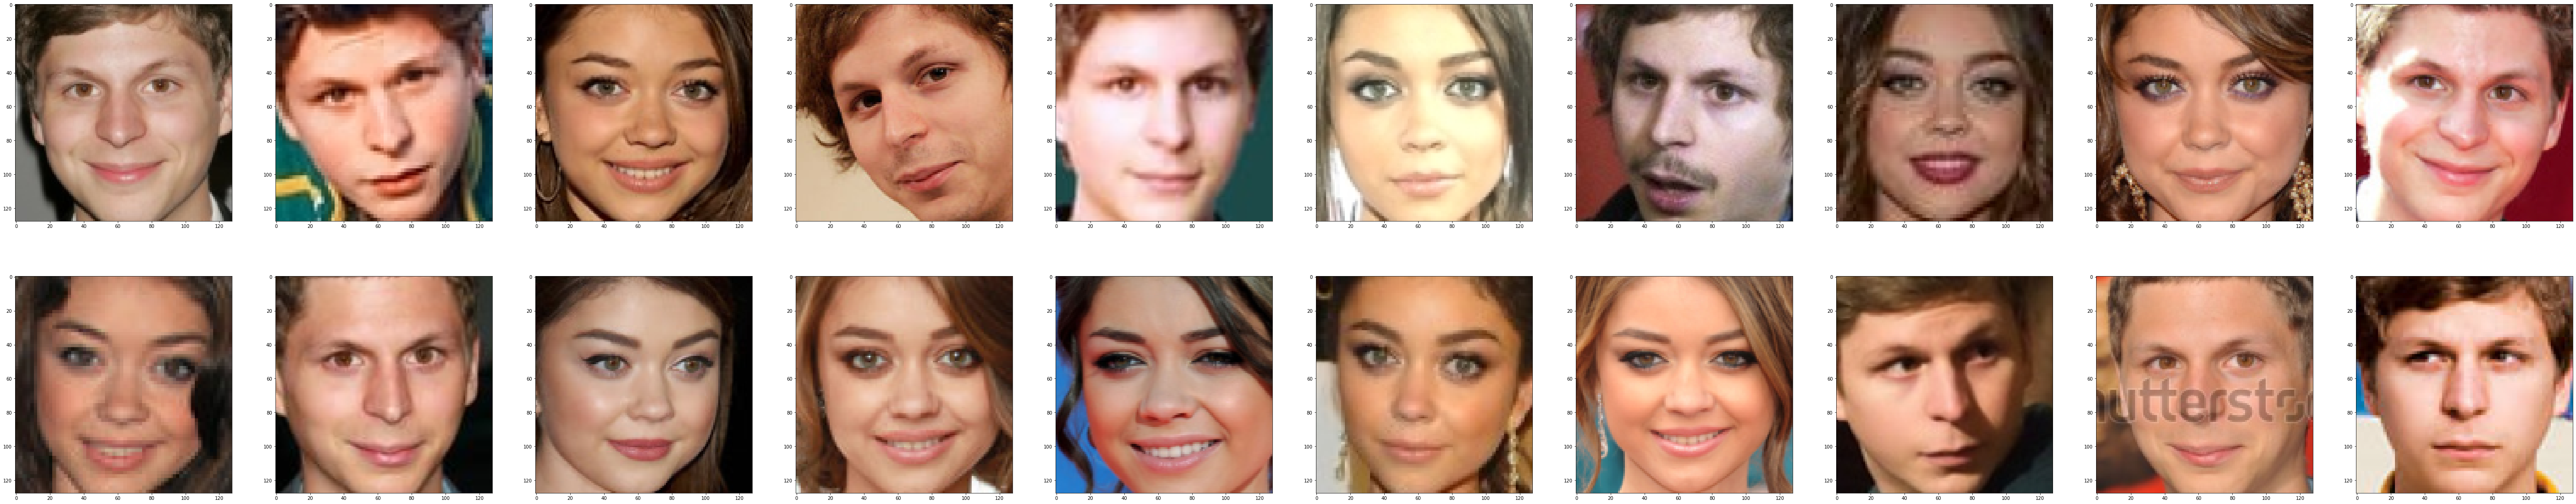

In [66]:
# plot faces of Michael and Sarah
plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


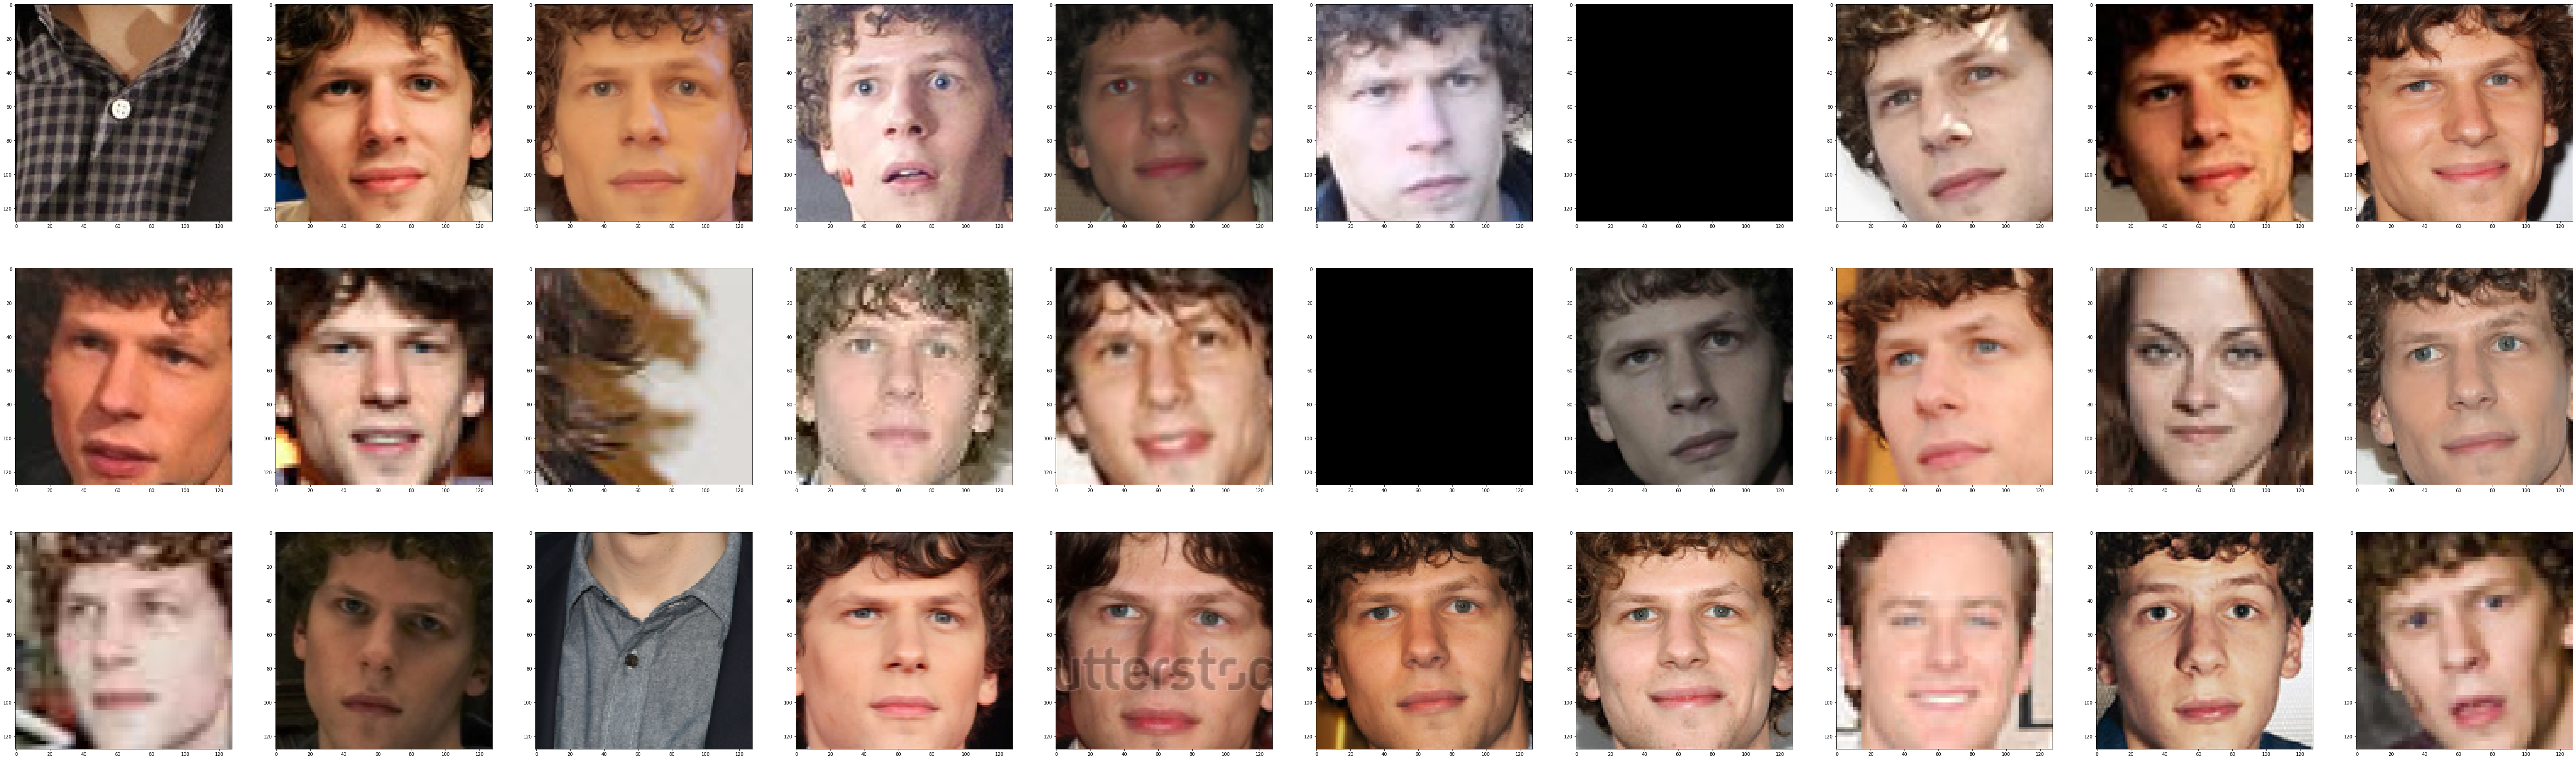

In [6]:
# plot faces of Jesse
plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

In [ ]:
# plot faces of Mila
plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [ ]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

## 0.5 FACE ALIGNMENT

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [ ]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform
[OpenCV document](https://docs.opencv.org/4.x/d5/d33/structcv_1_1HOGDescriptor.html#a723b95b709cfd3f95cf9e616de988fc8)


[OpenCV tutorial](https://learnopencv.com/histogram-of-oriented-gradients/)

In [ ]:
class HOGFeatureExtractor():
# class HOGFeatureExtractor(IdentityFeatureExtractor):

    """TODO: this feature extractor is under construction"""
    
    def __init__(self):
#         self.params = params
        # Initialize hog parameters
        winSize = (96, 96)
        blockSize = (8, 8)
        blockStride = (8, 8)
        cellSize = (4, 4)
        nbins = 9
        derivAperture = 0
        winSigma = 4.0
        histogramNormType = 1
        L2HysThreshold = 2.0000000000000001e-01
        gammaCorrection = 1
        nlevels = 64

        self.hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, 
                              nbins,derivAperture, winSigma, 
                              histogramNormType,L2HysThreshold, 
                              gammaCorrection, nlevels, 1)        
    
    def __call__(self, X):
        return self.transform(X)
            
    def transform(self, X):
        ### Feature computation for the training and testing data  ##
        features = []
        for face in X:
            features.append(self.hog.compute(np.uint8(face)))
        return np.array(features).squeeze()
#         raise NotImplmentedError

Create HOG feature extractor object and compute features

In [ ]:
HFE = HOGFeatureExtractor()

In [ ]:
HOG_train = HFE.transform(train_X)


### 1.1.1. t-SNE Plots
Steps:
* "The first step in the t-SNE algorithm involves measuring the distance from one point with respect to every other point. Instead of working with the distances directly, we map them to a probability distribution."

#### TODO
* Create a class for visualization using TSNE and PCA
* Visualize the Eigenfaces
* Complete discution and documentation

#### Some resources
* https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
* Nice example of ploting ->https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#helper-function-to-plot-embedding

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
z = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(HOG_train)
z.shape

In [ ]:
tsne = TSNE(
        n_components=2,
        init="pca",
#         learning_rate="auto",
#         n_iter=500,
#         n_iter_without_progress=150,
#         n_jobs=3,
#         random_state=0,
    )
z = tsne.fit_transform(HOG_train)

In [ ]:
df = pd.DataFrame()
df["y"] = train_y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="T-SNE projection")

### 1.1.2. Discussion
...

## 1.2. Baseline 2: PCA feature extractor
### Resourc
* PCA+Eigenfaces -> https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html

In [ ]:
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [ ]:
# class PCAFeatureExtractor():
class PCAFeatureExtractor(IdentityFeatureExtractor):

    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components):
        self.n_components = n_components
        
    def transform(self, X):
        self.pca = PCA(n_components=self.n_components, svd_solver="randomized", whiten=True)
        self.pca.fit(X)
        return self.pca.transform(X)
        
    def inverse_transform(self, X):
        raise NotImplmentedError

In [ ]:
PCA_obj = PCAFeatureExtractor(n_components=2)
PCA_train = PCA_obj.transform(HOG_train)

df = pd.DataFrame()
df["y"] = train_y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="PCA projection")

### 1.2.1. Eigenface Plots
...

### 1.2.2. Feature Space Plots
...

### 1.2.3. Discussion
...

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [ ]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [ ]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

## 3.1. Baseline 1: My favorite classifier
...

In [ ]:
class FavoriteClassificationModel:
    """TODO: this classifier is under construction."""
    def __init__(self):
        param_grid = {"C": loguniform(1e3, 1e5),
                      "gamma": loguniform(1e-4, 1e-1)}
        self.clf = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10)
    
    def __call__(self, X):
        return self.predict(X)
        
    def fit(self, X, y):
        t0 = time()
        self.clf = self.clf.fit(X, y)
        print("Trained in %0.3fs" % (time() - t0))
        print("Best estimator found by grid search:")
        print(self.clf.best_estimator_)
        
    def predict(self, X):
        y_pred = self.clf.predict(X)
        return y_pred

## 3.2. My second favorite classifier
...

In [ ]:
class FavoriteClassificationModel:
    """TODO: A very nice Siamese network XD"""
    def __init__(self,img):
        self.img = img

    
    def __call__(self, X):
        return self.predict(X)
        
    def fit(self, X, y):
        
    def predict(self, X):


# 4 DATA AUGMENTATION
...

In [22]:
class Data_augmentation():
    
    def __init__(self,n_augmentations_byclass = 2,class_label = "class"):
        """
        -Input:

        @param int n_augmentations_byclass: number of linear combinations taken per class
        @param str class_label: name of the column containing the class label
        """
        self.n_augmentations_byclass = n_augmentations_byclass
        self.class_label = class_label
        
        
    def increase_brightness_contrast(self, img, alpha, beta):
        
        """
        -Description: Increase brightness or/and contrast of the images in the dataframe 


        -Input:

        @param img : correspond to row of dataframe
        @param alpha: Contrast control (1.0-3.0)   (alpha = 1 is the original image contrast)
        @param beta : Brightness control (0-100)    (beta = 0 is the original image brightness)

        -Returns:

        @output new_image: new img after increasing contrast and/or brightness
        """
        img = img[0]
        new_image=cv2.addWeighted(img,alpha,np.zeros(img.shape, img.dtype),0,beta)
        return new_image

    def gaussian_blur(self,img,kernel):
        """
        -Description: add a gaussian blur to input img 


        -Input:

        @param img : correspond to row of dataframe
        @param kernel : kernel size of gaussian

        -Returns:

        @output new_image: new img after gaussian blur
        """
        img = img[0]
        new_img = cv2.GaussianBlur(img, (kernel,kernel), 1, 1, cv2.BORDER_DEFAULT)
        return new_img
    
    def flip_images(self,img,orientation):
        """
        -Description: flip the image horizontally


        -Input:

        @param img : correspond to row of dataframe

        -Returns:

        @output new_image: img after horizontal flip
        """
        img = img[0]
        new_img = cv2.flip(img,orientation)
        return new_img
    def augment(self,df,alpha1=1, beta1=50,alpha2=1.3,beta2=0,kernel=5,orientation=5):
        
        #define dataframes
        df_buffer = df.copy()
        df = df.drop(['name', 'class'],axis=1)
        df_brightness = df.copy()
        df_contrast  = df.copy()
        df_small_gaussian_blur = df.copy()
        df_flip = df.copy()
        
        #apply function to each of the dataframe
        df_brightness['img'] = df_brightness.apply(self.increase_brightness_contrast,args=(alpha1, beta1),axis=1)
        df_contrast['img'] = df_contrast.apply(self.increase_brightness_contrast,args=(alpha2, beta2),axis=1)
        df_small_gaussian_blur['img'] = df_small_gaussian_blur.apply(self.gaussian_blur,args=([kernel]),axis=1)
        df_flip['img'] = df_flip.apply(self.flip_images,args=([orientation]),axis=1)
        
        #add back class and name columns
        df_brightness['name'] = df_buffer['name']
        df_contrast['name'] = df_buffer['name']
        df_small_gaussian_blur['name'] = df_buffer['name']
        df_flip['name'] = df_buffer['name']
        df_brightness['class'] = df_buffer['class']
        df_contrast['class'] = df_buffer['class']
        df_small_gaussian_blur['class'] = df_buffer['class']
        df_flip['class'] = df_buffer['class']
        

        #append all created dataframe to original one (df)
        df_buffer = df_buffer.append([df_brightness,df_contrast,df_small_gaussian_blur,df_flip] , sort = True)
        return df_buffer
        
augmenter = Data_augmentation()
train_augmented = augmenter.augment(train,alpha1=1, beta1=50,alpha2=1.3,beta2=0,kernel=5,orientation=5)
print(train_augmented.shape)

(400, 3)


In [ ]:

test = train.iloc[2]
print(test)
test = test.drop(['name', 'class'])
test = np.array(test)[0]
# new_image=cv2.addWeighted(test,1,np.zeros(test.shape, test.dtype),0,1)
print(test.shape)
new_image=cv2.addWeighted(test,1,np.zeros(test.shape, test.dtype),3,0)
plt.imshow(new_image)
plt.show()


In [ ]:
grouped_classes = train.groupby("class",observed = True)
for class_name,group in grouped_classes:
    print(type(group))

## some experiments on data augmentation : 

In [ ]:
print(train_X[0].shape)

In [ ]:
print(train_X[0])

In [ ]:
plt.imshow(train_X[0])
plt.show()

In [ ]:
#Increase brightness or/and contrast to the image
#to create a new sample 

"""
increase_brightness_contrast(img, alpha=3,beta=0)  : max contrast, no change in brightness
increase_brightness_contrast(img, alpha=1,beta=100)  : max brightness, no change in contrast

"""


def increase_brightness_contrast(img, alpha,beta):


    # alpha is Contrast control (1.0-3.0)   (alpha = 1 is the original image contrast)
    #beta is Brightness control (0-100)    (beta = 0 is the original image brightness)
    
    # change the dtype to 'float32' (to be able to use ) cv2.cvtColor
    img = img.astype('uint8')

    new_image=cv2.addWeighted(img,alpha,np.zeros(img.shape, img.dtype),0,beta)
    
    return new_image

In [ ]:
img = train_X[0]
print(type(img))
print(img.shape)

# #hsv = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
frame = increase_brightness_contrast(img, alpha=3,beta=0)

plt.imshow(frame)
plt.show()
plt.imshow(img)
plt.show()

In [ ]:
#ADD RANDOM NOISE

def gaussian_blur(img,kernel):
    img = img.astype('uint8')
    frame = cv2.GaussianBlur(img, (kernel,kernel), 1, 1, cv2.BORDER_DEFAULT)
    
    return frame


In [ ]:
img = train_X[0]
print(type(img))

frame = gaussian_blur(img,5)
plt.imshow(frame)
plt.show()
plt.imshow(img)
plt.show()

In [ ]:
def flip_images(img):
    img = img.astype('uint8')
    frame = cv2.flip(img)
    
    return frame

    
    

In [ ]:
img = train_X[0]
print(type(img))
img = img.astype('uint8')
frame = cv2.flip(img,5)
plt.imshow(frame)
plt.show()
plt.imshow(img)
plt.show()

In [ ]:
def horizontal_flip:

In [ ]:
#ROTATION OF THE IMAGE

#...
#this will lead to sizing problem (we will have areas without pixels) ? I am not sure if it will help for the classification 

In [ ]:
#the data is train_X, train_y
#the class train_y has 3 possible values : [0,1,2]  (we have 3 classes)
#if it is allowed, we can also use libraries such as MxNet
class DataAugmentation:
    
    #horizontal flip

# 5 CNN
...

In [31]:
print("whole training sample shape :", train_X.shape, "whole labels shape :", train_y.shape )
print("one sample shape : ", train_X[train_y == 2][0].shape)
print("one sample values : ", train_X[train_y == 2][3])

whole training sample shape : (80, 128, 128, 3) whole labels shape : (80,)
one sample shape :  (128, 128, 3)
one sample values :  [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [52]:
print(train.head())

    class                                                img          name
id                                                                        
0       2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...    Mila_Kunis
1       2  [[[24, 35, 31], [25, 36, 32], [27, 36, 33], [2...    Mila_Kunis
2       0  [[[111, 112, 106], [111, 112, 106], [112, 113,...  Michael_Cera
3       2  [[[223, 223, 223], [223, 223, 223], [223, 223,...    Mila_Kunis
4       0  [[[195, 195, 205], [195, 195, 205], [190, 192,...  Michael_Cera


In [62]:
train_X = train["img"]
train_y = train["class"]

train_X = np.array(train_X)
print(train_X[0])

[[[ 50  31  25]
  [ 49  30  24]
  [ 49  30  24]
  ...
  [ 59  54  61]
  [ 63  57  67]
  [ 65  59  73]]

 [[ 50  31  25]
  [ 50  31  25]
  [ 49  30  23]
  ...
  [ 56  51  58]
  [ 60  54  64]
  [ 62  56  68]]

 [[ 52  32  25]
  [ 52  32  25]
  [ 52  32  23]
  ...
  [ 53  47  51]
  [ 57  50  57]
  [ 58  51  59]]

 ...

 [[ 97   6  21]
  [ 92   0  13]
  [ 96   2  16]
  ...
  [180  56  64]
  [176  52  60]
  [169  45  53]]

 [[104  13  28]
  [ 96   4  17]
  [ 98   4  18]
  ...
  [172  48  56]
  [173  49  57]
  [169  45  53]]

 [[111  20  35]
  [102  10  23]
  [103   9  23]
  ...
  [162  38  46]
  [165  41  49]
  [170  46  54]]]


In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Create 3 callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss',      #if validation_loss has not been reduced after 3 epochs, the learning rate is reduced to have a more "fine" learning
                              factor=0.5,
                              patience=3,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy',  #if the validation_accuracy does not get better after 6 epoch, the training is stopped
                               patience=30,
                               verbose=1)
checkpoint = ModelCheckpoint(filepath = 'checkpoint_wsh', #if the new model has a better validation_accuracy compared to the one at the previous epoch, the weight of the model are saved in checkpoint_cnn_best
                             monitor='val_accuracy',           #at the end of the training, the best model will be in checkpoint_cnn_best
                             save_best_only=True,
                             save_weights_only=True,
                             verbose=1)

In [79]:
#create model

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import struct 

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold


#First, we need to preprocess : normalize the values (divide by 255)
print(train_X.shape)
#input shape of image
input_shape = train_X.shape[1:4]
#number of classes
number_of_class = len(np.unique(train_y))
#train_validation split (no test set for now)
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

#normalization of pixels value
X_train_normalized = X_train/255
X_val_normalized = X_val/255

model = Sequential([                                                                   
    Conv2D(64, (7,7),activation='relu', padding="same", input_shape=input_shape),   
    #BatchNormalization(),
    MaxPool2D((2, 2)),  
    Conv2D(32, (5,5), activation='relu', padding="same"),   
    #BatchNormalization(),
    MaxPool2D((2, 2)),    
    Flatten(),                                                                    
    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(number_of_class, activation='softmax'), 

])
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #we use cross_entropy because we used softmax in the last layer
hist = model.fit(X_train_normalized, y_train, epochs=100, verbose=1, validation_data=(X_val_normalized,y_val), callbacks=[reduce_lr, checkpoint])
                                                                                  

(80, 128, 128, 3)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 128, 128, 64)      9472      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 32)        51232     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               4194432   
_________________________________________________________________
dropout_4 (Dropout)          (None,

KeyboardInterrupt: 

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(hist.history['val_loss'])
plt.title('model cnn loss')
plt.ylabel('categorical crossentropy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [80]:
model.load_weights('checkpoint_wsh')

In [85]:
new_test_set = pd.read_csv('new_test_set.csv')
img_test = test.iloc[:100]
new_try = img_test.join(new_test_set['class'])
new_try

img  class
id                                                          
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...      1
1   [[[146, 113, 36], [147, 114, 37], [147, 114, 3...      0
2   [[[194, 192, 193], [194, 192, 193], [193, 193,...      0
3   [[[121, 121, 121], [121, 121, 121], [121, 121,...      0
4   [[[228, 228, 230], [228, 228, 230], [228, 228,...      1
..                                                ...    ...
95  [[[216, 220, 232], [216, 220, 232], [217, 221,...      0
96  [[[166, 44, 41], [168, 46, 43], [169, 47, 44],...      0
97  [[[219, 216, 223], [219, 216, 223], [218, 215,...      0
98  [[[25, 25, 27], [25, 25, 27], [25, 25, 27], [2...      1
99  [[[27, 20, 27], [26, 19, 26], [24, 17, 24], [2...      2

[100 rows x 2 columns]

In [86]:
x_test_normalized, y_test = preprocessor(new_try), new_try['class'].values
x_test_normalized = x_test_normalized/255
print(x_test_normalized[0])
print(x_test_normalized.shape)
print(y_test)
print(y_test.shape)

[[[0.03529412 0.03921569 0.01960784]
  [0.05490196 0.05490196 0.03921569]
  [0.07843137 0.0627451  0.05098039]
  ...
  [0.13333333 0.07058824 0.03137255]
  [0.18039216 0.12156863 0.09019608]
  [0.20392157 0.12941176 0.09803922]]

 [[0.04313725 0.04313725 0.02352941]
  [0.08235294 0.07058824 0.05882353]
  [0.08235294 0.0627451  0.05098039]
  ...
  [0.15686275 0.09411765 0.04705882]
  [0.16862745 0.10980392 0.08627451]
  [0.19215686 0.11764706 0.09411765]]

 [[0.11764706 0.10980392 0.09019608]
  [0.08627451 0.07058824 0.05490196]
  [0.07843137 0.05882353 0.04313725]
  ...
  [0.15294118 0.10588235 0.07058824]
  [0.15686275 0.09803922 0.05882353]
  [0.19215686 0.10980392 0.06666667]]

 ...

 [[0.8627451  0.87058824 0.86666667]
  [0.8627451  0.87058824 0.86666667]
  [0.85882353 0.86666667 0.8627451 ]
  ...
  [0.69803922 0.51764706 0.45490196]
  [0.69019608 0.50588235 0.44705882]
  [0.65882353 0.48627451 0.42352941]]

 [[0.8627451  0.87058824 0.86666667]
  [0.8627451  0.87058824 0.86666667]


In [87]:
print(test_X.shape, y_test.shape)
img_test = test_X[:100]
print(img_test.shape, y_test.shape)


(1816, 128, 128, 3) (100,)
(100, 128, 128, 3) (100,)


In [88]:
evalu = model.evaluate(x_test_normalized, y_test, verbose=0) #evaluate the model with the testing set (set which never has been seen by the model)
print(f'Loss on the test set: {evalu[0]}')  #categorical_crossentropy
print(f'Accuracy on the test set: {evalu[1]}')  #accuracy

Loss on the test set: 0.9972575306892395
Accuracy on the test set: 0.8125


# 5 SIAMESE
...

In [141]:
# Input data files are available in the read-only "../input/" directory
# csv_train_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train_set.csv'
# csv_test_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test_set.csv'
# npy_train_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'
# npy_test_path = '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'


###
# IMPORTANT
# MODIFY THE FOLLOWING PATHS
###
csv_train_path = 'data/train_set.csv'
csv_test_path = 'data/test_set.csv'
npy_train_path = 'data/train/train_{}.npy'
npy_test_path = 'data/test/test_{}.npy'

train = pd.read_csv(csv_train_path, index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(csv_test_path, index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load(npy_train_path.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load(npy_test_path.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

In [159]:
# parameter to play with 
FACE_SIZE = (96, 96)
    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values


In [89]:
# import the necessary packages
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np


def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    print("mallé fieu", numClasses)
    print("wsh", numClasses)
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        currentImage = images[idxA]
        label = labels[idxA]
        # randomly pick an image that belongs to the *same* class
        # label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        # prepare a positive pair and update the images and labels
        # lists, respectively
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    # return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels))

def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [90]:
# import the necessary packages
import os
# specify the shape of the inputs for our network
IMG_SHAPE = (96, 96, 3)
# specify the batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 1000


# define the path to the base output directory
BASE_OUTPUT = "output"
# use the base output path to derive the path to the serialized
# model along with training history plot
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

In [91]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D


def build_siamese_model(inputShape, embeddingDim=128):
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(16, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(32, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # build the model
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

In [98]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

trainX = X_train/255
trainY = y_train

testX = X_test/255
testY = y_test
# add a channel dimension to the images
# trainX = np.expand_dims(trainX, axis=-1)
# testX = np.expand_dims(testX, axis=-1)
# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)

IMG_SHAPE = (128, 128, 3)

# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# compile the model
print("[INFO] compiling model...")
model.compile(optimizer = "adam",loss="binary_crossentropy",metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
                    batch_size=BATCH_SIZE, epochs=EPOCHS,callbacks=[reduce_lr, checkpoint])

# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)
# plot the training history
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

[INFO] loading MNIST dataset...
[INFO] preparing positive and negative pairs...
mallé fieu 3
wsh 3
mallé fieu 3
wsh 3
[INFO] building siamese network...
[INFO] compiling model...
[INFO] training model...
Epoch 1/1000
4/4 [==============================] - ETA: 0s - loss: 289773.9062 - accuracy: 0.5000
Epoch 00001: val_accuracy improved from -inf to 0.40000, saving model to checkpoint_wsh
4/4 [==============================] - 1s 168ms/step - loss: 289773.9062 - accuracy: 0.5000 - val_loss: 212115.2188 - val_accuracy: 0.4000
Epoch 2/1000
4/4 [==============================] - ETA: 0s - loss: 159735.0469 - accuracy: 0.5000
Epoch 00002: val_accuracy did not improve from 0.40000
4/4 [==============================] - 1s 134ms/step - loss: 159735.0469 - accuracy: 0.5000 - val_loss: 123791.0156 - val_accuracy: 0.4000
Epoch 3/1000
4/4 [==============================] - ETA: 0s - loss: 80362.3047 - accuracy: 0.5000
Epoch 00003: val_accuracy did not improve from 0.40000
4/4 [===================

Epoch 57/1000
4/4 [==============================] - ETA: 0s - loss: 452.4782 - accuracy: 0.5250
Epoch 00057: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 139ms/step - loss: 452.4782 - accuracy: 0.5250 - val_loss: 56.1204 - val_accuracy: 0.4500
Epoch 58/1000
4/4 [==============================] - ETA: 0s - loss: 410.3012 - accuracy: 0.5250
Epoch 00058: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 133ms/step - loss: 410.3012 - accuracy: 0.5250 - val_loss: 54.4885 - val_accuracy: 0.4500
Epoch 59/1000
4/4 [==============================] - ETA: 0s - loss: 367.6432 - accuracy: 0.5167
Epoch 00059: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 138ms/step - loss: 367.6432 - accuracy: 0.5167 - val_loss: 52.7245 - val_accuracy: 0.4500
Epoch 60/1000
4/4 [==============================] - ETA: 0s - loss: 392.1157 - accuracy: 0.5167
Epoch 00060: val_accuracy did not improve from 0.50

Epoch 85/1000
4/4 [==============================] - ETA: 0s - loss: 304.0788 - accuracy: 0.5167
Epoch 00085: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 143ms/step - loss: 304.0788 - accuracy: 0.5167 - val_loss: 36.9627 - val_accuracy: 0.4500
Epoch 86/1000
4/4 [==============================] - ETA: 0s - loss: 212.4956 - accuracy: 0.5250
Epoch 00086: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 153ms/step - loss: 212.4956 - accuracy: 0.5250 - val_loss: 36.8611 - val_accuracy: 0.4500
Epoch 87/1000
4/4 [==============================] - ETA: 0s - loss: 281.7056 - accuracy: 0.5250
Epoch 00087: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 146ms/step - loss: 281.7056 - accuracy: 0.5250 - val_loss: 36.7857 - val_accuracy: 0.4500
Epoch 88/1000
4/4 [==============================] - ETA: 0s - loss: 251.1353 - accuracy: 0.5250
Epoch 00088: val_accuracy did not improve from 0.50

Epoch 112/1000
4/4 [==============================] - ETA: 0s - loss: 218.6233 - accuracy: 0.5083
Epoch 00112: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 137ms/step - loss: 218.6233 - accuracy: 0.5083 - val_loss: 36.7911 - val_accuracy: 0.4500
Epoch 113/1000
4/4 [==============================] - ETA: 0s - loss: 246.0257 - accuracy: 0.5250
Epoch 00113: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 139ms/step - loss: 246.0257 - accuracy: 0.5250 - val_loss: 36.7905 - val_accuracy: 0.4500
Epoch 114/1000
4/4 [==============================] - ETA: 0s - loss: 284.3777 - accuracy: 0.5167
Epoch 00114: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 00114: val_accuracy did not improve from 0.50000
4/4 [==============================] - 1s 144ms/step - loss: 284.3777 - accuracy: 0.5167 - val_loss: 36.7904 - val_accuracy: 0.4500
Epoch 115/1000
4/4 [==============================] - ETA: 0s -

KeyboardInterrupt: 

## face recognition with MTCNN and SVM

In [ ]:
https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/
https://www.kaggle.com/code/stoicstatic/face-recognition-siamese-w-triplet-loss/notebook

In [8]:
#MCTNN is a library that help to create a face detector using Multitask Cascaded Convolutional Networks
#https://medium.com/clique-org/how-to-create-a-face-recognition-model-using-facenet-keras-fd65c0b092f1
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [74]:
print(train)

            name  class                                                img
id                                                                        
0     Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...
1     Mila_Kunis      2  [[[24, 35, 31], [25, 36, 32], [27, 36, 33], [2...
2   Michael_Cera      0  [[[111, 112, 106], [111, 112, 106], [112, 113,...
3     Mila_Kunis      2  [[[223, 223, 223], [223, 223, 223], [223, 223,...
4   Michael_Cera      0  [[[195, 195, 205], [195, 195, 205], [190, 192,...
..           ...    ...                                                ...
75    Mila_Kunis      2  [[[222, 230, 233], [222, 230, 233], [222, 230,...
76  Michael_Cera      0  [[[194, 54, 39], [195, 53, 39], [196, 53, 39],...
77    Mila_Kunis      2  [[[240, 251, 24], [236, 252, 3], [228, 251, 0]...
78    Mila_Kunis      2  [[[153, 149, 122], [153, 149, 122], [153, 149,...
79  Michael_Cera      0  [[[117, 171, 218], [117, 171, 218], [118, 172,...

[80 rows x 3 columns]


In [5]:
print(type(train))

<class 'pandas.core.frame.DataFrame'>


### Face detection with MTCNN

(160, 160, 3)


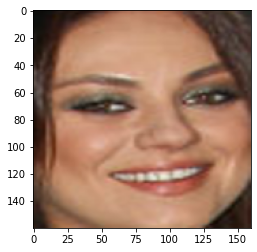

In [36]:
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import logging
import tensorflow 
tensorflow.get_logger().setLevel(logging.ERROR)

"""
for some samples, we are not able to detect the face
so, the results dic is empty
when looking for face = pixels[y1:y2, x1:x2], it gives
an error
what we can do is to remove theses images without faces from the training set
and for the test set, what we can do is to "copy" the samples dic of the previous
samples : it will be an error but at least not make the code bug

"""
# extract a single face from a given photograph
def extract_face(dataset, required_size=(160, 160)):
    images = np.array(dataset)
    images = Image.fromarray(images, "RGB") 
    # convert to array
#     print(images.getbands())
    pixels = asarray(images)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
#     print(results)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load the photo and extract the face
face = extract_face(training_set['img'][52])
print(face.shape)
plt.imshow(face)

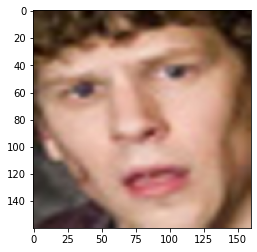

In [37]:
# load images and extract faces for all images in a directory
def load_faces(dataframe):
    faces = list()
    # enumerate files
    for i in range (0,len(dataframe)):
        face = extract_face(dataframe["img"][i])
        faces.append(face)
    return faces

In [38]:
def create_dataset(dataframe):
    X = list()
    y = list()
    faces = load_faces(dataframe)
    X.extend(faces)
    y.extend(dataframe["class"])
    return asarray(X), asarray(y) 
    

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train["img"], train["class"], test_size=0.2, random_state=42)
training_set = pd.DataFrame(X_train)
training_set["class"] = y_train
training_set = training_set.reset_index()
# drop buggy samples (I mean faces are not detected)
training_set = training_set.drop(29)
training_set = training_set.reset_index()
# drop buggy samples (I mean faces are not detected)
# validation_set = validation_set.drop(19,27)
# validation_set = validation_set.reset_index()


validation_set = pd.DataFrame(X_val)
validation_set["class"] = y_val
validation_set = validation_set.reset_index()

# load train dataset
trainX, trainy = create_dataset(training_set)
print(trainX.shape, trainy.shape)
# load val dataset
valX, valy = create_dataset(validation_set)
print(valX.shape, valy.shape)

(63, 160, 160, 3) (63,)
(16, 160, 160, 3) (16,)


In [40]:
np.savez_compressed('mtcnn_dataset.npz', trainX, trainy, valX, valy)

### Create face embedding

In [41]:
#we will have faceNET to create face embeddings
data = np.load('mtcnn_dataset.npz',allow_pickle=True)
trainX, trainy, valX, valy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, valX.shape, valy.shape)


Loaded:  (63, 160, 160, 3) (63,) (16, 160, 160, 3) (16,)


In [42]:
from tensorflow.keras.models import load_model


#environment needed for model : 
# Ubuntu16.04 or Windows10
# python3.6.2
# tensorflow: 1.3.0
# keras: 2.1.2
    
#we will use the facenet model£
model = load_model('facenet_model/model/facenet_keras.h5')
print('Loaded Model')



Loaded Model


In [43]:
# #now, we need to preprocess the pixels before feeding them to faceNet

# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [44]:
from numpy import expand_dims

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the val set to an embedding
newValX = list()
for face_pixels in valX:
    embedding = get_embedding(model, face_pixels)
    newValX.append(embedding)
newValX = asarray(newValX)
print(newValX.shape)
# save arrays to one file in compressed format
np.savez_compressed('MTCNN_embeddings.npz', newTrainX, trainy, newValX, valy)

(63, 128)
(16, 128)


### Classification

In [45]:
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from numpy import load

#load the embeddings 
data = load('MTCNN_embeddings.npz')
trainX, trainy, valX, valy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, val=%d' % (trainX.shape[0], valX.shape[0]))

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
valX = in_encoder.transform(valX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
valy = out_encoder.transform(valy)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
valy = out_encoder.transform(valy)
# fit model
model_SVC = SVC(kernel='linear', probability=True)
model_SVC.fit(trainX, trainy)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(trainX, trainy)

# predict
yhat_train = model_SVC.predict(trainX)
yhat_val = model_SVC.predict(valX)

yhat_train_knn = neigh.predict(trainX)
yhat_val_knn = neigh.predict(valX)
# score
score_train_SVC = accuracy_score(trainy, yhat_train)
score_val_SVC = accuracy_score(valy, yhat_val)

score_train_knn = accuracy_score(trainy, yhat_train_knn)
score_val_knn = accuracy_score(valy, yhat_val_knn)
# summarize
print('Accuracy svc: train=%.3f, val=%.3f' % (score_train_SVC*100, score_val_SVC*100))
print('Accuracy knn: train=%.3f, val=%.3f' % (score_train_knn*100, score_val_knn*100))

Dataset: train=63, val=16
Accuracy svc: train=100.000, val=93.750
Accuracy knn: train=98.413, val=87.500


### classification with cnn

In [19]:
#create model

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import struct 

import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
print(trainX)

#First, we need to preprocess : normalize the values (divide by 255)
print(trainX.shape)
#input shape of image
input_shape = trainX.shape[1:4]
#number of classes
number_of_class = len(np.unique(trainy))


model = Sequential([                                                                   
    Conv2D(64, (7,7),activation='relu', padding="same", input_shape=input_shape),   
    #BatchNormalization(),
    MaxPool2D((2, 2)),  
    Conv2D(32, (5,5), activation='relu', padding="same"),   
    #BatchNormalization(),
    MaxPool2D((2, 2)),    
    Flatten(),                                                                    
    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(number_of_class, activation='softmax'), 

])
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #we use cross_entropy because we used softmax in the last layer
hist = model.fit(trainX, trainy, epochs=100, verbose=1, validation_data=(valX,valy), callbacks=[reduce_lr, checkpoint])
              

[[-0.17430489 -0.13530381 -0.0523957  ...  0.05284578  0.11370436
   0.02154701]
 [ 0.09807765 -0.04850211  0.11943313 ... -0.2152871  -0.0840036
   0.04413566]
 [-0.13492675 -0.26198396  0.02317795 ...  0.06645807  0.23691432
   0.11288223]
 ...
 [-0.03278016 -0.15790227  0.10287541 ...  0.0125731   0.12939967
   0.08138736]
 [-0.19482782 -0.09970953 -0.09362084 ...  0.14637837  0.11037447
   0.04360196]
 [-0.19008306 -0.12964709  0.00947871 ...  0.04241797  0.08062541
   0.05624609]]
(62, 128)


ValueError: Input 0 of layer conv2d_938 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 128)

### Performance on the test set

In [85]:
new_test_set = pd.read_csv('new_test_set.csv')
img_test = test.iloc[:100]
new_try = img_test.join(new_test_set['class'])
print(new_try)

                                                  img  class
id                                                          
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...      1
1   [[[146, 113, 36], [147, 114, 37], [147, 114, 3...      0
2   [[[194, 192, 193], [194, 192, 193], [193, 193,...      0
3   [[[121, 121, 121], [121, 121, 121], [121, 121,...      0
4   [[[228, 228, 230], [228, 228, 230], [228, 228,...      1
..                                                ...    ...
95  [[[216, 220, 232], [216, 220, 232], [217, 221,...      0
96  [[[166, 44, 41], [168, 46, 43], [169, 47, 44],...      0
97  [[[219, 216, 223], [219, 216, 223], [218, 215,...      0
98  [[[25, 25, 27], [25, 25, 27], [25, 25, 27], [2...      1
99  [[[27, 20, 27], [26, 19, 26], [24, 17, 24], [2...      2

[100 rows x 2 columns]


In [86]:
#sample 91 are buggy (I mean faces are not detected)
new_try = new_try.iloc[:90]
new_try = new_try.reset_index()
testX, testy = create_dataset(new_try)


In [87]:
np.savez_compressed('mtcnn_dataset_test.npz', testX, testy)

In [88]:
#we will have faceNET to create face embeddings
data_test = load('mtcnn_dataset_test.npz')
testX, testy = data_test['arr_0'], data_test['arr_1']
print('Loaded: ', testX.shape, testy.shape)


Loaded:  (90, 160, 160, 3) (90,)


In [89]:
from numpy import expand_dims
# get the face embedding for one face
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
np.savez_compressed('MTCNN_embeddings_test.npz', newTestX, testy)

(90, 128)


In [20]:
#load the embeddings 
data = load('MTCNN_embeddings_test.npz')
print(data)
testX, testy = data['arr_0'], data['arr_1']
print('Dataset test',testX.shape[0])

# normalize input vectors
in_encoder = Normalizer(norm='l2')
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
testy = out_encoder.transform(testy)

# predict
yhat_test = model_SVC.predict(testX)
# score
score_test = accuracy_score(testy, yhat_test)
# summarize
print("Accuracy: test is",score_test*100)

Dataset test 90
Accuracy: test is 87.77777777777777


# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42
)

In [ ]:
# feature_extractor = IdentityFeatureExtractor() 
# classifier = RandomClassificationModel()

feature_extractor = HOGFeatureExtractor() 
classifier = FavoriteClassificationModel()

# train the model on the features
classifier.fit(feature_extractor(X_train), y_train)

# model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [ ]:
# evaluate performance of the model on the training set
train_y_star = model(X_test)

"The performance on the training set is {:.4f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(y_test, train_y_star))

## Visual check of the data

In [ ]:
y_test

In [ ]:
train_y_star

# 5. Publishing best results

In [ ]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

In [ ]:
submission.to_csv('submission.csv')

# 6. Discussion
...

In summary we contributed the following: 
* 
